In [1]:
!pip install transformers torch pandas matplotlib seaborn wordcloud scikit-learn nltk
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
from tqdm import tqdm
import torch

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Ganti path dengan lokasi file Anda
file_path = '/content/drive/MyDrive/Kuliah/Semester 4/Penambangan Data/UAS/data_ulasan_satusehat.csv'
df = pd.read_csv(file_path)

# Pastikan kolom yang diperlukan ada
print("Kolom yang tersedia:", df.columns.tolist())
print(f"Jumlah data: {len(df)} ulasan")

# Tampilkan contoh data
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Kolom yang tersedia: ['content', 'score']
Jumlah data: 1048 ulasan


,content,score
0,"aplikasi jelek, pas zaman nya covid pernah daf...",1
1,"Haduh,, aplikasi pemerintah lagi. Apresiasi ad...",1
2,"admin, saya tidak bisa masuk ke aplikasi, nges...",4
3,"apk nya banyak bug, mau edit profil udh ditung...",4
4,kenapa ya setiap mau donwload sertifikat vaksi...,2


In [3]:
# PREPROCESSING

# Stopwords lengkap + kata generik aplikasi
id_stopwords = set(stopwords.words('indonesian'))
custom_stopwords = {
    'yg', 'nya', 'sih', 'dgn', 'aja', 'deh', 'dong', 'yah', 'nih', 'ya', 'ga', 'gak',
    'dan', 'di', 'ke', 'dari', 'itu', 'ini', 'saya', 'aku', 'kita', 'kamu', 'sbg', 'tsb','tdk', 'nge',
    'aplikasi', 'app', 'satusehat', 'satu', 'sehat', 'kesehatan', 'banget'
}
all_stopwords = id_stopwords | custom_stopwords | set(STOPWORDS)

def intensive_clean(text):
    # Cleaning dasar
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)          # Remove URLs
    text = re.sub(r'[^\w\s]', ' ', text)          # Remove special chars
    text = re.sub(r'\d+', '', text)               # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()      # Simplify spaces

    # Tokenize dan filter
    tokens = text.split()
    tokens = [word for word in tokens if
              (word not in all_stopwords) and
              (len(word) > 2)]

    return " ".join(tokens)

df['Cleaned'] = df['content'].apply(intensive_clean)

# Hapus baris kosong
df = df[df['Cleaned'].str.len() > 5].reset_index(drop=True)

print("Contoh hasil:")
print("Original:", df['content'].iloc[0])
print("Cleaned :", df['Cleaned'].iloc[0])

Contoh hasil:
Original: aplikasi jelek, pas zaman nya covid pernah daftar, tp skrng mau masuk lagi malah data nya ilang, cuma email dan nomor hp yang masih terverifikasi, giliran udah masuk cek profil malah kosong, data nya, mau di perbaharui gak bisa
Cleaned : jelek pas zaman covid daftar skrng masuk data ilang email nomor terverifikasi giliran udah masuk cek profil kosong data perbaharui


In [20]:
# ANALISIS SENTIMEN

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="mdhugol/indonesia-bert-sentiment-classification",
    device="cpu"  # Gunakan 'cuda' jika Anda memiliki GPU yang kompatibel
)
print(f"Device set to use {sentiment_analyzer.device}")

# 1. Gunakan model yang lebih spesifik
model_name = "mdhugol/indonesia-bert-sentiment-classification"

# 2. Turunkan threshold confidence
def classify_with_threshold(text):
    if len(text) < 3:
        return 'netral', 0.0

    result = sentiment_analyzer(text, truncation=True)[0]
    top_label = result['label']
    confidence = result['score']

    # Threshold lebih rendah (0.6)
    if confidence < 0.6:
        # Ambil label dengan skor tertinggi meski confidence rendah
        return top_label, confidence
    return top_label, confidence

# 3. Perbaiki preprocessing: Kembalikan kata negasi penting
custom_stopwords = {
    'yg', 'nya', 'sih', 'dgn', 'aja', 'deh', 'dong', 'yah', 'nih', 'ya',
    'dan', 'di', 'ke', 'dari', 'itu', 'ini', 'sbg', 'tsb', 'tdk', 'nge',
    'aplikasi', 'app', 'satusehat', 'satu', 'sehat', 'kesehatan', 'banget'
}
# JANGAN hapus kata negasi penting
preserve_words = {'tidak', 'bukan', 'jangan', 'gagal', 'error'}
all_stopwords = id_stopwords | custom_stopwords | set(STOPWORDS) - preserve_words

# 4. Proses ulang
print("Memproses ulang ulasan dengan perbaikan...")
sentiments = []
confidences = []

# Gunakan teks original yang lebih kaya konteks
for text in tqdm(df['content'].tolist()):
    result = classify_with_threshold(text)
    sentiments.append(result[0])
    confidences.append(result[1])

# Mapping label yang lebih sesuai dengan model
label_map = {'LABEL_2': 'positif', 'LABEL_1': 'netral', 'LABEL_0': 'negatif'}
df['Sentimen'] = [label_map.get(s.upper(), 'netral') for s in sentiments]
df['Confidence'] = confidences


# 5. Distribusi baru
distribusi = df['Sentimen'].value_counts(normalize=True) * 100
print("\nDistribusi Sentimen (Perbaikan):")
print(distribusi)

Device set to use cpu


Device set to use cpu
Memproses ulang ulasan dengan perbaikan...


100%|██████████| 1048/1048 [05:15<00:00,  3.32it/s]


Distribusi Sentimen (Perbaikan):
Sentimen
positif    81.488550
netral     14.217557
negatif     4.293893
Name: proportion, dtype: float64


/tmp/ipython-input-18-1102669481.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['Sentimen'],


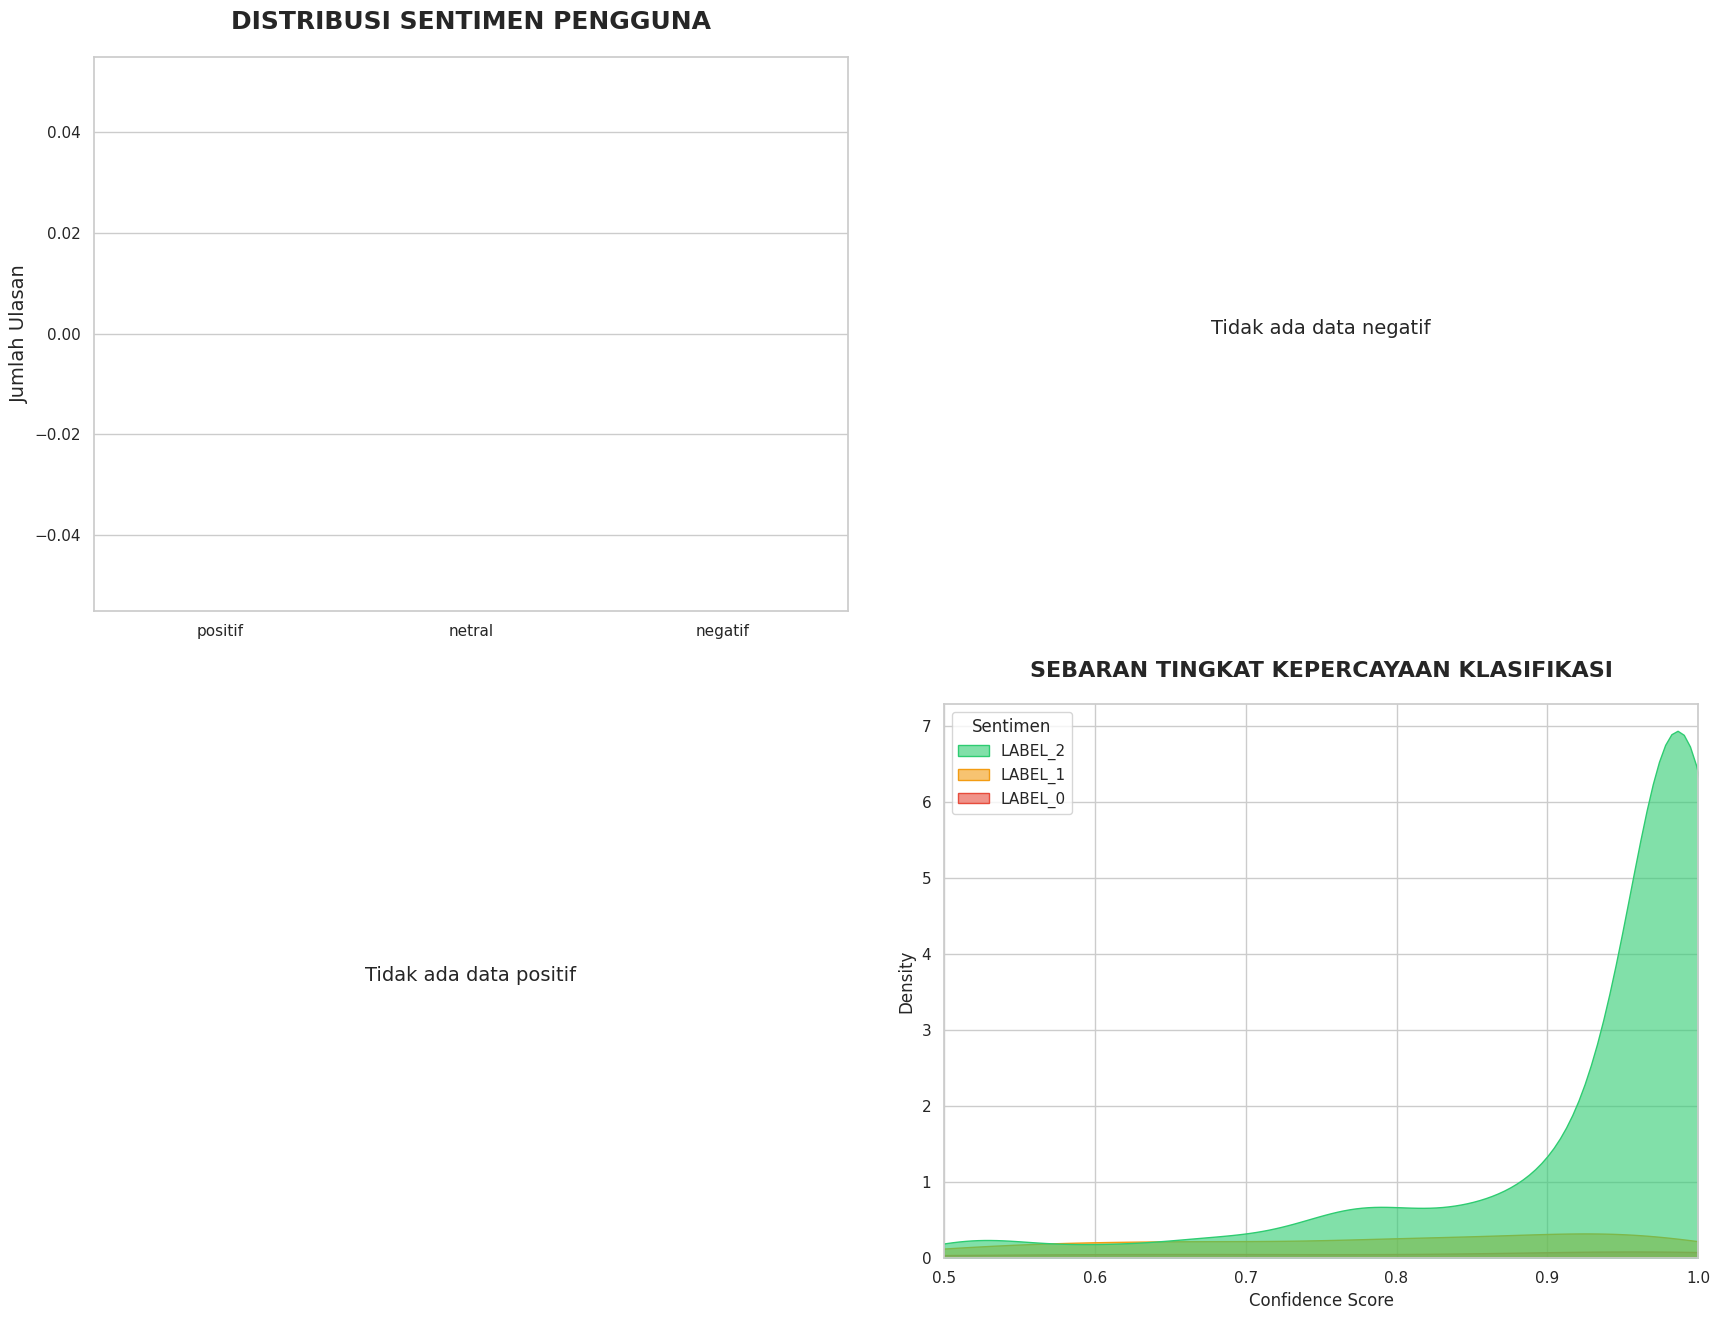

In [18]:
# VISUALISASI & ANALISIS TOPIK

# Setting
sns.set(style="whitegrid", font="DejaVu Sans", rc={'axes.titlepad': 20})
plt.figure(figsize=(18, 14))

# 1. Distribusi Sentimen
plt.subplot(2, 2, 1)
ax = sns.countplot(x=df['Sentimen'],
                  order=['positif', 'netral', 'negatif'],
                  palette=['#2ecc71', '#f39c12', '#e74c3c'])
plt.title("DISTRIBUSI SENTIMEN PENGGUNA", fontsize=18, weight='bold')
plt.xlabel("")
plt.ylabel("Jumlah Ulasan", fontsize=14)

# Anotasi persentase
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 5,
            f'{height/total*100:.1f}%',
            ha='center', fontsize=13)

# 2. Wordcloud Negatif
plt.subplot(2, 2, 2)
neg_text = " ".join(df[df['Sentimen'] == 'negatif']['Cleaned'])
if neg_text.strip():
    wc = WordCloud(width=800, height=500, background_color='white',
                   colormap='Reds', max_words=100, stopwords=set(),
                   min_font_size=10).generate(neg_text)
    plt.imshow(wc, interpolation='bilinear')
    plt.title("KATA KUNCI KELUHAN UTAMA", fontsize=16, weight='bold')
    plt.axis('off')
else:
    plt.text(0.5, 0.5, 'Tidak ada data negatif', ha='center', fontsize=14)
    plt.axis('off')

# 3. Wordcloud Positif
plt.subplot(2, 2, 3)
pos_text = " ".join(df[df['Sentimen'] == 'positif']['Cleaned'])
if pos_text.strip():
    wc = WordCloud(width=800, height=500, background_color='white',
                   colormap='Greens', max_words=100, stopwords=set(),
                   min_font_size=10).generate(pos_text)
    plt.imshow(wc, interpolation='bilinear')
    plt.title("KATA KUNCI PUJIAN UTAMA", fontsize=16, weight='bold')
    plt.axis('off')
else:
    plt.text(0.5, 0.5, 'Tidak ada data positif', ha='center', fontsize=14)
    plt.axis('off')

# 4. Confidence Distribution
plt.subplot(2, 2, 4)
sns.kdeplot(data=df, x='Confidence', hue='Sentimen',
            palette=['#2ecc71', '#f39c12', '#e74c3c'], fill=True, alpha=0.6)
plt.title("SEBARAN TINGKAT KEPERCAYAAN KLASIFIKASI", fontsize=16, weight='bold')
plt.xlabel("Confidence Score", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xlim(0.5, 1.0)

plt.tight_layout(pad=3.0)
plt.savefig('HASIL_ANALISIS.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# TOPIK UTAMA PER SENTIMEN
from collections import Counter

def get_top_phrases(texts, n=20, min_length=4):
    """Ekstrak frasa penting dari kumpulan teks"""
    all_phrases = []
    for text in texts:
        words = text.split()
        # Buat bigram dan trigram
        phrases = [' '.join(words[i:i+2]) for i in range(len(words)-1)]
        phrases += [' '.join(words[i:i+3]) for i in range(len(words)-2)]
        # Filter frasa bermakna
        phrases = [p for p in phrases if len(p.split()) > 1 and len(p) > min_length]
        all_phrases.extend(phrases)
    return Counter(all_phrases).most_common(n)

print("\n TOP NEGATIF:")
neg_texts = df[df['Sentimen']=='negatif']['Cleaned']
top_neg = get_top_phrases(neg_texts)
for phrase, count in top_neg:
    print(f" - {phrase} ({count})")

print("\n TOP POSITIF:")
pos_texts = df[df['Sentimen']=='positif']['Cleaned']
top_pos = get_top_phrases(pos_texts)
for phrase, count in top_pos:
    print(f" - {phrase} ({count})")


 TOP NEGATIF:
 - akses lokasi (5)
 - terima kasih (4)
 - sertifikat vaksin (4)
 - pilih tema (2)
 - login ulang (2)
 - tgl mei (2)
 - mengunduh sertifikat (2)
 - mohon perbaiki (2)
 - mengunduh sertifikat vaksin (2)
 - hasil lab (2)
 - tensi tekanan (2)
 - tekanan darah (2)
 - gula darah (2)
 - tensi tekanan darah (2)
 - password email (2)
 - nada dering (2)
 - boros baterai (2)
 - kode otp (2)
 - menekan tombol (2)
 - aturan perjalanan (2)

 TOP POSITIF:
 - sertifikat vaksin (96)
 - peduli lindungi (63)
 - tolong diperbaiki (57)
 - tolong perbaiki (51)
 - scan barcode (43)
 - berkali kali (37)
 - kode verifikasi (33)
 - tanggal lahir (31)
 - mohon diperbaiki (26)
 - kode otp (23)
 - akun terdaftar (21)
 - tgl lahir (20)
 - download sertifikat (19)
 - instal ulang (18)
 - akses lokasi (18)
 - isi data (17)
 - sertifikat muncul (16)
 - masuk mall (16)
 - nik nama (16)
 - terima kasih (15)


In [15]:
# EKSPOR HASIL
# Simpan data lengkap
df_output = df[['content', 'Sentimen', 'Confidence', 'Cleaned']]
df_output.to_csv('HASIL_ANALISIS.csv', index=False, encoding='utf-8-sig')

# Buat laporan ringkasan
report = f"""
LAPORAN ANALISIS SENTIMEN APLIKASI SATUSEHAT
Jumlah Ulasan: {len(df)}
Distribusi Sentimen:
   - Positif: {distribusi.get('positif', 0):.1f}%
   - Netral: {distribusi.get('netral', 0):.1f}%
   - Negatif: {distribusi.get('negatif', 0):.1f}%

TOP 5 KEYWORD NEGATIF:
{chr(10).join([f' - {p[0]} ({p[1]})' for p in top_neg[:5]])}

TOP 5 KEYWORD POSITIF:
{chr(10).join([f' - {p[0]} ({p[1]})' for p in top_pos[:5]])}
"""

print(report)
with open('LAPORAN_RINGKASAN.txt', 'w') as f:
    f.write(report)

print("Proses selesai! Lihat hasilnya pada files berikut:")
print("- HASIL_ANALISIS.csv")
print("- LAPORAN_RINGKASAN.txt")
print("- HASIL_ANALISIS.png")


LAPORAN ANALISIS SENTIMEN APLIKASI SATUSEHAT
Jumlah Ulasan: 1048
Distribusi Sentimen:
   - Positif: 81.5%
   - Netral: 14.2%
   - Negatif: 4.3%

TOP 5 KEYWORD NEGATIF:
 - akses lokasi (5)
 - terima kasih (4)
 - sertifikat vaksin (4)
 - pilih tema (2)
 - login ulang (2)

TOP 5 KEYWORD POSITIF:
 - sertifikat vaksin (96)
 - peduli lindungi (63)
 - tolong diperbaiki (57)
 - tolong perbaiki (51)
 - scan barcode (43)

Proses selesai! Lihat hasilnya pada files berikut:
- HASIL_ANALISIS.csv
- LAPORAN_RINGKASAN.txt
- HASIL_ANALISIS.png
